In [1]:
#import necessary modules
import numpy as np
import matplotlib.pyplot as plt

import dill

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn import svm

import keras
from keras.datasets import fashion_mnist 
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.utils import to_categorical

#this can be used to center the image at center of mass
#import scipy.ndimage.measurements.center_of_mass

/Users/derek/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/derek/miniconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/derek/miniconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/derek/miniconda3/lib/python3.6/site-p

In [2]:
reload_profiles_from_disk=False

In [6]:
#load the energy density and flow profiles, and freezeout radii 
#note that the physics here is rotationally invariant
#we can exploit this to copy each profile 3 times, by rotating by 90 degrees each time
#and using the same radius
n_profiles = 100
if reload_profiles_from_disk:
    e_profiles = []
    u_profiles = []
    radii = []
    for i in range(n_profiles):
        e = np.loadtxt('profiles_and_radii/' + str(i) + '/e_projection.dat-0.dat')
        u = np.loadtxt('profiles_and_radii/' + str(i) + '/u_tau_projection.dat-0.dat')
    
        #first let's cut of the edges of these profiles (empty space)
        #and coarse grain the profiles by a factor
        e = e[70:270:8,70:270:8]
        u = u[70:270:8,70:270:8]    
    
        #the physics is invariant under rotations and parity
        e_profiles.append(e)
        e_profiles.append( np.rot90(e) )
        e_profiles.append( np.rot90( np.rot90(e) ) )
        e_profiles.append( np.rot90( np.rot90(np.rot90(e) ) ) )
        e_profiles.append( np.flipud(e) )
        e_profiles.append( np.fliplr(e) )
    
        #u_profiles.append(u)
        #u_profiles.append( np.rot90(u) )
        #u_profiles.append( np.rot90( np.rot90(u) ) )
        #u_profiles.append( np.rot90( np.rot90( np.rot90(u) ) ) )
   
        try :
            r = np.loadtxt('profiles_and_radii/' + str(i) + '/radius.dat-0.dat')
            for i in range(6):
                radii.append(r)
        except :
            #no radius file exists when radius is zero (no freezeout surface)
            for i in range(6):
                radii.append(0.)
        
    e_profiles = np.array(e_profiles)
    u_profiles = np.array(u_profiles)
    radii = np.array(radii)

    #dump these to disk
    with open('e.dill', 'wb') as e_file:
        dill.dump(e_profiles, e_file)
    with open('r.dill', 'wb') as r_file:
        dill.dump(radii, r_file)

In [7]:
with open('e.dill','rb') as e_file:
    e_profiles = dill.load(e_file)
with open('r.dill','rb') as r_file:
    radii = dill.load(r_file)

In [8]:
#get the dimensions of each image
profile_shape = e_profiles[0].shape
print("profile_shape = " + str(profile_shape))
n_profiles *= 6 #4 copies of each profile for 4 orienatation angles 

profile_shape = (25, 25)


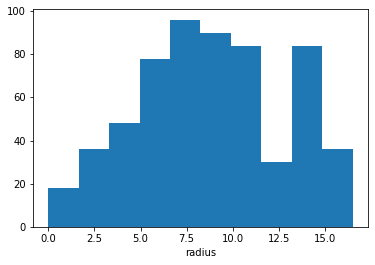

In [9]:
#lets look at the distribution of radii
plt.hist(radii)
plt.xlabel('radius')
plt.show()

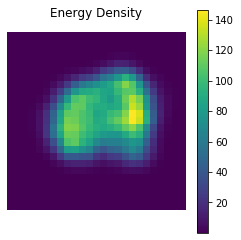

radius = 16.503943612


In [10]:
#lets look at an energy density and flow profile
choice = 10
mat = plt.matshow(e_profiles[choice])
cbar = plt.colorbar(mat)
plt.title("Energy Density")
plt.axis('off')
plt.show()
print("radius = " + str(radii[choice]))

In [11]:
#lets define our own global scaling function, that preserves the physics
#a larger energy density normalization -> larger radius
def global_scaler(X):
    X *= (1.0/X.max())
    return X

In [12]:
#Lets first try to train a model using only the energy density
#our features are the energy density profile, and 'labels' are the radii
X = e_profiles
y = radii

#reshape the features and targets to 2D array 
X = X.reshape((n_profiles, profile_shape[0]**2))

In [13]:
#use global scaler 
X_scaled = global_scaler(X)

#split into training and testing sets 
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state=1, shuffle=False)

#use standardscaler
#X_scaler = StandardScaler()
#X_scaler.fit(X_train)
 
#use minmaxscaler
#X_scaler = MinMaxScaler(feature_range=(0,1))

#use normalizer
#X_scaler = Normalizer()
#y_scaler = Normalizer()

#X_train = X_scaler.transform(X_train)
#X_test = X_scaler.transform(X_test)

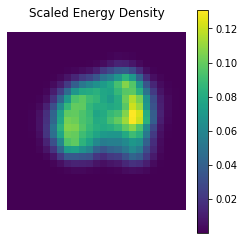

In [14]:
mat = plt.matshow(X_train[choice].reshape(profile_shape))
cbar = plt.colorbar(mat)
plt.title("Scaled Energy Density")
plt.axis('off')
plt.show()

In [15]:
#Linear Regression fits the training set because of overfitting! (too many parameters)
#first we need to do PCA
pca = PCA(0.95)
pca.fit(X_train) #fit the transformation to only the training data
print("Explained variance ratio = " + str(pca.explained_variance_ratio_))  
print("Singular Values = " + str(pca.singular_values_)) 

Explained variance ratio = [0.87077673 0.0244857  0.01672022 0.01508675 0.01234704 0.00796001
 0.00593446]
Singular Values = [12.82589962  2.15075391  1.77727829  1.68823238  1.52726997  1.22628468
  1.05882662]


In [16]:
#transform the data
X_train_pc = pca.transform(X_train)
X_test_pc = pca.transform(X_test)
print(X_test_pc.shape)
#mat = plt.matshow(X_train_pc[choice].reshape(profile_shape))
#cbar = plt.colorbar(mat)
#plt.title("Scaled Energy Density")
#plt.axis('off')
#plt.show()

(120, 7)


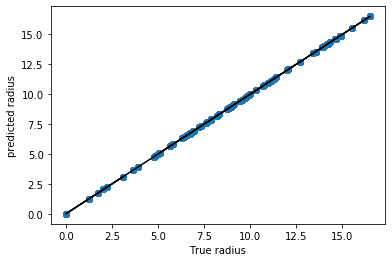

In [19]:
#Linear Regression
lin_reg_model = LinearRegression().fit(X_train, y_train)
lin_predictions = lin_reg_model.predict(X_train) 
plt.scatter(y_train, lin_predictions)
plt.plot(y_train, y_train, color='black')
plt.xlabel('True radius')
plt.ylabel('predicted radius')
plt.show()

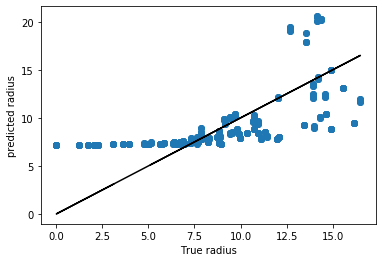

In [20]:
#we can try Support Vector Machines for SVM Regression
svr_linear_model = svm.SVR(kernel='linear', gamma='auto', C=2.0, epsilon=0.1)
svr_linear_model.fit(X_train, y_train)
svr_linear_predictions = svr_linear_model.predict(X_train) 
plt.scatter(y_train, svr_linear_predictions)
plt.plot(y_train, y_train, color='black')
plt.xlabel('True radius')
plt.ylabel('predicted radius')
plt.show()

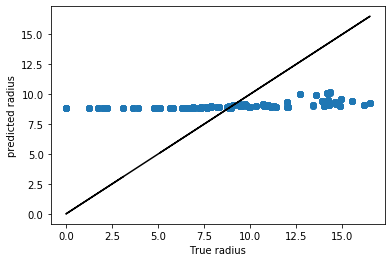

In [21]:
#SVM with RBF kernel
svr_rbf_model = svm.SVR(kernel='rbf', gamma = 'auto', C=1.0, epsilon=0.1)
svr_rbf_model.fit(X_train, y_train)
svr_rbf_predictions = svr_rbf_model.predict(X_train)
plt.scatter(y_train, svr_rbf_predictions)
plt.plot(y_train, y_train, color='black')
plt.xlabel('True radius')
plt.ylabel('predicted radius')
plt.show()

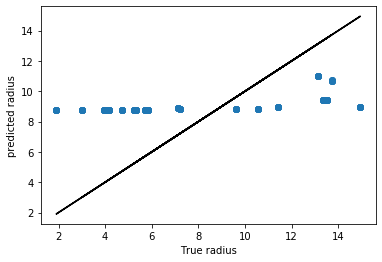

In [22]:
svr_poly_model = svm.SVR(kernel='poly', gamma='auto', degree=3, epsilon=.5,
               coef0=1)
svr_poly_model.fit(X_train, y_train)
svr_poly_predictions = svr_poly_model.predict(X_test)
plt.scatter(y_test, svr_poly_predictions)
plt.plot(y_test, y_test, color='black')
#plt.xlim(0,15)
#plt.ylim(0,15)
plt.xlabel('True radius')
plt.ylabel('predicted radius')
plt.show()

In [23]:
#try CNN
X_train = X_train.reshape(-1, 50, 50, 1)
X_test = X_test.reshape(-1, 50, 50, 1)

cnn_model = Sequential()
cnn_model.add(Conv2D(64, (3,3), input_shape=(50, 50, 1)))
cnn_model.add(Activation('relu'))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))
cnn_model.add(Conv2D(64, (3,3)))
cnn_model.add(Activation('relu'))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))
cnn_model.add(Flatten())
#cnn_model.add(Dense(64))
cnn_model.add(Dense(1))
cnn_model.compile(loss=keras.losses.mean_squared_error, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])
cnn_model.fit(X_train, y_train, batch_size=64, epochs=10)

Instructions for updating:
Colocations handled automatically by placer.


ValueError: Input arrays should have the same number of samples as target arrays. Found 120 input samples and 480 target samples.

In [ ]:
cnn_predictions = cnn_model.predict(X_train)
plt.scatter(y_train, cnn_predictions)
plt.plot(y_train, y_train, color='black')
#plt.xlim(0,12)
#plt.ylim(0,12)
plt.xlabel('True radius')
plt.ylabel('predicted radius')
plt.show()